In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline

In [2]:
from IPython.display import clear_output

# Inputs:
bas_tot = 1000 # Total number of samples for baseline calculation
fl_total = 24 # Total number of files

# Pulse processing for each event
# For this test, channels 1 and 3 will be used because the pulses are unipolar
evt_smp = 100000 # Number of samples in an event
evt_acc = 0 # accumulated number of events

evt_total_est = 100 # Total number of events estimative per file (only for specify the length of array)

# Initialize timing arrays
dif_LED = np.zeros(evt_total_est*fl_total) # diference of times of LED method for each event
dif_IRI = np.zeros(evt_total_est*fl_total) # diference of times of IRI method for each event
dif_MRI = np.zeros(evt_total_est*fl_total) # diference of times of IRI method for each event
tLED_error = 0 # Total number of error in method apply
tIRI_error = 0 # Total number of error in method apply
tMRI_error = 0 # Total number of error in method apply

# Initialize energy arrays
ene_y1 = np.zeros(evt_total_est*fl_total) # Energy for each event in channel 1
ene_y3 = np.zeros(evt_total_est*fl_total) # Energy for each event in channel 3

# Process each csv file
for chnk in range(fl_total):
    fth_file = "../results/test_" + str(chnk) + ".csv" # csv file name
    df = pd.read_csv(fth_file) # Data frame from file
    content = df.values # Data frame to Numpy array

    # Each column in Numpy array from Pandas data frame     
    x0 = np.array(content[:,0]) # Horizontal scale -> T = 0.001E-08 (-5.000E-08 - -4.999E-08) 
    #y0 = np.array(content[:,1]) # Vertical - Signal 0
    y1 = np.array(content[:,2]) # Vertical - Signal 1
    #y2 = np.array(content[:,3]) # Vertical - Signal 2
    y3 = np.array(content[:,4]) # Vertical - Signal 3

    evt_tot = int(len(df.index)/evt_smp) # Total number of events    

    clear_output(wait=False)
    print("File name: {} - Processing {} events...".format(fth_file, evt_tot))    
    
    # Process events
    for evt_nb in range(evt_tot):        
        #print("File name: {} - Processing {}/{} event...".format(fth_file, evt_nb+1, evt_tot))           
        # List of events with problems
        # Avoid these events
        blc_lst = []
        if chnk==7:
            blc_lst = [1, 45, 46, 47] # chnk = 7
        if chnk==17:
            blc_lst = [41] # chnk = 17 (see error after this event. It is necessary remove row=4200000)
        if chnk==18:
            blc_lst = [52, 53] # chnk = 18
        if chnk==19:
            blc_lst = [98] # chnk = 19 (pulse with pile-up?)
        if evt_nb in blc_lst:
            print("File name: {} - Skipping event number {}/{}...".format(fth_file, evt_nb+1, evt_tot))
            continue
        
        evt_sta = evt_nb * evt_smp # Event start
        evt_end = evt_sta + evt_smp - 1 # Event end
        evt_rng = range(evt_sta, evt_end) # Event range

        # Baseline calculation - Average Moving Method
        # In the Average Moving Method, the average is calculated from the beginning 
        # of the event to the sample referring to the trigger.
        # But for simplification, the average will be calculated up to bas_tot sample 
        
        bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
        bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    
        
        # Threshold calculation 
        # For simplification the threshold will be estimed in 6 sigmas aprox.
        thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
        thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

        # Trigger
        trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample (x axis) for channel 1
        trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample (x axis) for channel 3

        ## Timing methods:
        # 1- MRI (Leading Edge Discrimination)
        # 2- IRI (Initial Rise Interpolation) - https://doi.org/10.1109/NSSMIC.2009.5401926
        # 3- MRI (Maximum Rise Interpolation) - https://doi.org/10.1016/S0168-9002(02)00401-1

        # 1- LED
        tLED_t1 = trg_s1-1 + ((thr_y1 - y1[trg_s1-1]) / (y1[trg_s1] - y1[trg_s1-1]))
        if y1[trg_s1] - y1[trg_s1-1] == 0.0:
            tLED_error += 1            
            print("Error for LED in event ",evt_acc)
            print("Values: ",y1[trg_s1], y1[trg_s1-1])
            continue
        tLED_t3 = trg_s3-1 + ((thr_y3 - y3[trg_s3-1]) / (y3[trg_s3] - y3[trg_s3-1]))
        if y3[trg_s3] - y3[trg_s3-1] == 0.0:
            tLED_error += 1
            print("Error for LED in event ",evt_acc)
            print("Values: ",y3[trg_s3], y1[trg_s3-1])
            continue        
        
        # 2- IRI
        tIRI_t1 = trg_s1-1 - ((y1[trg_s1-1] - bas_y1) / (y1[trg_s1] - y1[trg_s1-1]))
        if y1[trg_s1] - y1[trg_s1-1] == 0.0:
            tIRI_error += 1            
            print("Error for IRI in event ",evt_acc)
            print("Values: ",y1[trg_s1], y1[trg_s1-1])
            continue       
        tIRI_t3 = trg_s3-1 - ((y3[trg_s3-1] - bas_y3) / (y3[trg_s3] - y3[trg_s3-1]))
        if y3[trg_s3] - y3[trg_s3-1] == 0.0:
            tIRI_error += 1            
            print("Error for IRI in event ",evt_acc)
            print("Values: ",y3[trg_s3], y3[trg_s3-1])
            continue        

        # 3- MRI
        tMRI_t1 = trg_s1 - ((y1[trg_s1] - bas_y1) / (y1[trg_s1+1] - y1[trg_s1]))
        if y1[trg_s1+1] - y1[trg_s1] == 0.0:
            tMRI_error += 1            
            print("Error for MRI in event ",evt_acc)
            print("Values: ",y1[trg_s1+1], y1[trg_s1])
            continue       
        tMRI_t3 = trg_s3 - ((y3[trg_s3] - bas_y3) / (y3[trg_s3+1] - y3[trg_s3]))
        if y3[trg_s3+1] - y3[trg_s3] == 0.0:
            tMRI_error += 1            
            print("Error for MRI in event ",evt_acc)
            print("Values: ",y3[trg_s3+1], y3[trg_s3])
            continue

        dif_LED[evt_acc] = tLED_t3 - tLED_t1
        dif_IRI[evt_acc] = tIRI_t3 - tIRI_t1 
        dif_MRI[evt_acc] = tMRI_t3 - tMRI_t1 
        
        evt_acc += 1
print("Total number of events:",evt_acc)
print("Total number of LED errors:",tLED_error)
print("Total number of IRI errors:",tIRI_error)
print("Total number of MRI errors:",tMRI_error)

File name: ../results/test_23.csv - Processing 99 events...
Total number of events: 2371
Total number of LED errors: 0
Total number of IRI errors: 0
Total number of MRI errors: 14


In [4]:
import datetime
now = datetime.datetime.now()

# Save time diff for LED method
dataset = pd.DataFrame({'dif_LED': dif_LED})
dif_LED_file = "../results/dif_LED_" + str(now.strftime("%Y-%m-%d_%H-%M-%S")) + ".csv"
dataset.to_csv(dif_LED_file)
# Save time diff for IRI method
dataset = pd.DataFrame({'dif_IRI': dif_IRI})
dif_IRI_file = "../results/dif_IRI_" + str(now.strftime("%Y-%m-%d_%H-%M-%S")) + ".csv"
dataset.to_csv(dif_IRI_file)
# Save time diff for MRI method
dataset = pd.DataFrame({'dif_MRI': dif_MRI})
dif_MRI_file = "../results/dif_MRI_" + str(now.strftime("%Y-%m-%d_%H-%M-%S")) + ".csv"
dataset.to_csv(dif_MRI_file)

In [3]:
# This step is not necessary if energy data has already been loaded.
# Read timing data
tLED_file = "../results/dif_LED_2022-04-18_16-44-13.csv"
df_LED = pd.read_csv(tLED_file) # Data frame from file
content = df_LED.values
dif_LED = np.array(content[:,1])

tIRI_file = "../results/dif_IRI_2022-04-18_16-44-13.csv"
df_IRI = pd.read_csv(tIRI_file) # Data frame from file
content = df_IRI.values
dif_IRI = np.array(content[:,1])

tMRI_file = "../results/dif_MRI_2022-04-18_16-44-13.csv"
df_MRI = pd.read_csv(tMRI_file) # Data frame from file
content = df_MRI.values
dif_MRI = np.array(content[:,1])

FileNotFoundError: [Errno 2] No such file or directory: '../results/dif_IRI_2022-04-18_16-44-13.csv'

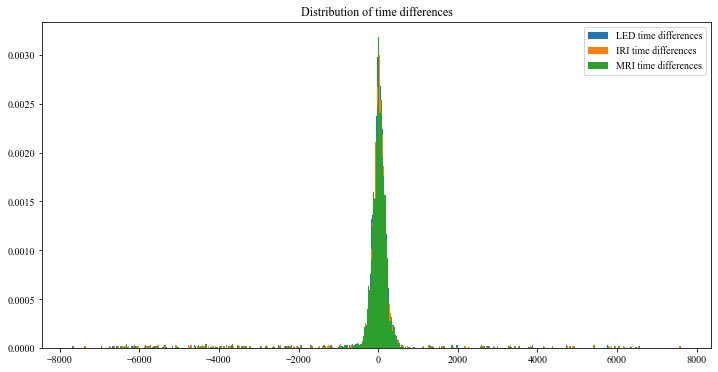

In [5]:
# Data analysis from timing pick-off

from scipy.stats import norm

plt.figure(figsize = (12, 6))
plt.title('Distribution of time differences')
LED = plt.hist(dif_LED, bins="auto", density=True, alpha=1, label='LED time differences')
IRI = plt.hist(dif_IRI, bins="auto", density=True, alpha=1, label='IRI time differences')
MRI = plt.hist(dif_MRI, bins="auto", density=True, alpha=1, label='MRI time differences')
# Mean and standard deviation
mean_LED, std_LED = norm.fit(dif_LED) 
mean_IRI, std_IRI = norm.fit(dif_IRI) 
mean_MRI, std_MRI = norm.fit(dif_MRI) 
# mean = dif_LED.mean()
# std = dif_LED.std()
# mean = np.average(x, weights=y)
# var = np.average((x - mean)**2, weights=y)
# std = np.sqrt(var)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p_LED = norm.pdf(x, mean_LED, std_LED)
# p_IRI = norm.pdf(x, mean_IRI, std_IRI)
# p_MRI = norm.pdf(x, mean_MRI, std_MRI)
# plt.plot(x, p_LED, '--', label='LED Gaussian fit')
# plt.plot(x, p_IRI, '--', label='IRI Gaussian fit')
# plt.plot(x, p_MRI, '--', label='MRI Gaussian fit')
plt.legend()
plt.show()

LED timing:
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 211
    # variables        = 3
    chi-square         = 3331.90890
    reduced chi-square = 16.0187928
    Akaike info crit   = 588.242374
    Bayesian info crit = 598.297948
[[Variables]]
    amplitude:  64367.0206 +/- 579.798267 (0.90%) (init = 66104.75)
    center:     25.6970662 +/- 1.38232823 (5.38%) (init = 36.27857)
    sigma:      132.903445 +/- 1.38232823 (1.04%) (init = 103.9383)
    fwhm:       312.963691 +/- 3.25513415 (1.04%) == '2.3548200*sigma'
    height:     193.213405 +/- 1.74038554 (0.90%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = 0.577
IRI timing:
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 203
    # variables        = 3
    chi-square         = 3647.9

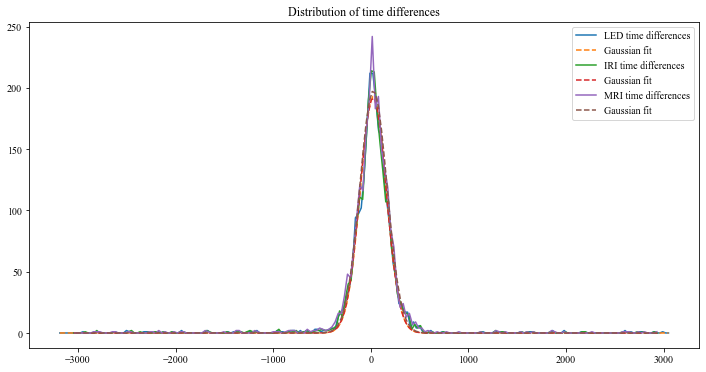

Coincidence Timing Resolution:
LED -> CTR: 3129.6 +/- 32.6 ps
IRI -> CTR: 3151.3 +/- 35.0 ps
MRI -> CTR: 3275.6 +/- 41.9 ps


In [20]:
# Data analysis from timing pick-off

## Check lmfit
try:
  import lmfit
except:
  %pip install lmfit
  import lmfit

from lmfit.models import GaussianModel

plt.figure(figsize = (12, 6))
plt.title('Distribution of time differences')
y_LED, bin_edges_LED = np.histogram(dif_LED, bins="auto")
x_LED = 0.5*(bin_edges_LED[1:] + bin_edges_LED[:-1]) # centering bin edges
y_IRI, bin_edges_IRI = np.histogram(dif_IRI, bins="auto")
x_IRI = 0.5*(bin_edges_IRI[1:] + bin_edges_IRI[:-1]) # centering bin edges
y_MRI, bin_edges_MRI = np.histogram(dif_MRI, bins="auto")
x_MRI = 0.5*(bin_edges_MRI[1:] + bin_edges_MRI[:-1]) # centering bin edges

# Mean and standard deviation
mean_LED, std_LED = norm.fit(dif_LED) 
llim_LED = mean_LED - 3*std_LED
ulim_LED = mean_LED + 3*std_LED
pkx_LED = x_LED[(llim_LED < x_LED) & (x_LED < ulim_LED)]
pky_LED = y_LED[(llim_LED < x_LED) & (x_LED < ulim_LED)]

mean_IRI, std_IRI = norm.fit(dif_IRI) 
llim_IRI = mean_IRI - 3*std_IRI
ulim_IRI = mean_IRI + 3*std_IRI
pkx_IRI = x_IRI[(llim_IRI < x_IRI) & (x_IRI < ulim_IRI)]
pky_IRI = y_IRI[(llim_IRI < x_IRI) & (x_IRI < ulim_IRI)]

mean_MRI, std_MRI = norm.fit(dif_MRI) 
llim_MRI = mean_MRI - 3*std_MRI
ulim_MRI = mean_MRI + 3*std_MRI
pkx_MRI = x_MRI[(llim_MRI < x_MRI) & (x_MRI < ulim_MRI)]
pky_MRI = y_MRI[(llim_MRI < x_MRI) & (x_MRI < ulim_MRI)]


# Report data analysis
mod = GaussianModel()
par_LED = mod.guess(pky_LED, x=pkx_LED)
out_LED = mod.fit(pky_LED, par_LED, x=pkx_LED)
print ("LED timing:")
print (out_LED.fit_report(min_correl=0.25))
oy_LED = out_LED.best_fit
par_IRI = mod.guess(pky_IRI, x=pkx_IRI)
out_IRI = mod.fit(pky_IRI, par_IRI, x=pkx_IRI)
print ("IRI timing:")
print (out_IRI.fit_report(min_correl=0.25))
oy_IRI = out_IRI.best_fit
par_MRI = mod.guess(pky_MRI, x=pkx_MRI)
out_MRI = mod.fit(pky_MRI, par_MRI, x=pkx_MRI)
print ("MRI timing:")
print (out_MRI.fit_report(min_correl=0.25))
oy_MRI = out_MRI.best_fit
plt.plot(pkx_LED, pky_LED, label='LED time differences')
plt.plot(pkx_LED, oy_LED , '--', label='Gaussian fit')
plt.plot(pkx_IRI, pky_IRI, label='IRI time differences')
plt.plot(pkx_IRI, oy_IRI , '--', label='Gaussian fit')
plt.plot(pkx_MRI, pky_MRI, label='MRI time differences')
plt.plot(pkx_MRI, oy_MRI , '--', label='Gaussian fit')
plt.legend()
plt.show()

resolution = 10 # 10 ps
print("Coincidence Timing Resolution:")
res_LED = out_LED.params['fwhm'].value  * resolution
sd_res_LED = out_LED.params['fwhm'].stderr * resolution 
print("LED -> CTR: {:.1f} +/- {:.1f} ps".format(res_LED, sd_res_LED))
res_IRI = out_IRI.params['fwhm'].value * resolution 
sd_res_IRI = out_IRI.params['fwhm'].stderr * resolution 
print("IRI -> CTR: {:.1f} +/- {:.1f} ps".format(res_IRI, sd_res_IRI))
res_MRI = out_MRI.params['fwhm'].value * resolution
sd_res_MRI = out_MRI.params['fwhm'].stderr * resolution 
print("MRI -> CTR: {:.1f} +/- {:.1f} ps".format(res_MRI, sd_res_MRI))
